In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from i import model_pred_train_dir, data_dir, model_pred_test_dir, submissions_dir
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

df = pd.concat(
    [
        pd.read_parquet(data_dir + "train_gp.parquet", columns=["GP_0", "GP_1"]),
        pd.read_parquet(model_pred_train_dir + "train_prob_gp.parquet").rename(columns={"loan_paid_back_probability_GP": "geneprog"}),
        pd.read_parquet(model_pred_train_dir + "train_prob_linear.parquet", columns=["ridge"]),
        pd.read_parquet(model_pred_train_dir + "train_prob_tree.parquet", columns=["lgb"]),
        pd.read_parquet(data_dir + "train_feature.parquet"),
    ],
    axis=1,
)

X_pred = pd.concat(
    [
        pd.read_parquet(data_dir + "test_gp.parquet", columns=["GP_0", "GP_1"]),
        pd.read_parquet(model_pred_test_dir + "test_prob_gp.parquet").rename(columns={"loan_paid_back_probability_GP": "geneprog"}),
        pd.read_parquet(model_pred_test_dir + "test_prob_linear.parquet", columns=["ridge"]),
        pd.read_parquet(model_pred_test_dir + "test_prob_tree.parquet", columns=["lgb"]),
        pd.read_parquet(data_dir + "test_feature.parquet"),
    ],
    axis=1,
)

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

df = df[df.select_dtypes(exclude="category").columns]
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_pred = X_pred[X_pred.select_dtypes(exclude="category").columns]
    
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 593994 entries, 0 to 593993
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   GP_0                        593994 non-null  float64
 1   GP_1                        593994 non-null  float64
 2   geneprog                    593994 non-null  float64
 3   ridge                       593994 non-null  float64
 4   lgb                         593994 non-null  float64
 5   annual_income               593994 non-null  float64
 6   debt_to_income_ratio        593994 non-null  float64
 7   credit_score                593994 non-null  int64  
 8   loan_amount                 593994 non-null  float64
 9   interest_rate               593994 non-null  float64
 10  annual_incomeXcredit_score  593994 non-null  float64
 11  loan_to_income              593994 non-null  float64
 12  interest_burden             593994 non-null  float64
 13  log_income         

In [2]:
X_pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 254569 entries, 593994 to 848562
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   GP_0                        254569 non-null  float64
 1   GP_1                        254569 non-null  float64
 2   geneprog                    254569 non-null  float64
 3   ridge                       254569 non-null  float64
 4   lgb                         254569 non-null  float64
 5   annual_income               254569 non-null  float64
 6   debt_to_income_ratio        254569 non-null  float64
 7   credit_score                254569 non-null  int64  
 8   loan_amount                 254569 non-null  float64
 9   interest_rate               254569 non-null  float64
 10  annual_incomeXcredit_score  254569 non-null  float64
 11  loan_to_income              254569 non-null  float64
 12  interest_burden             254569 non-null  float64
 13  log_income    

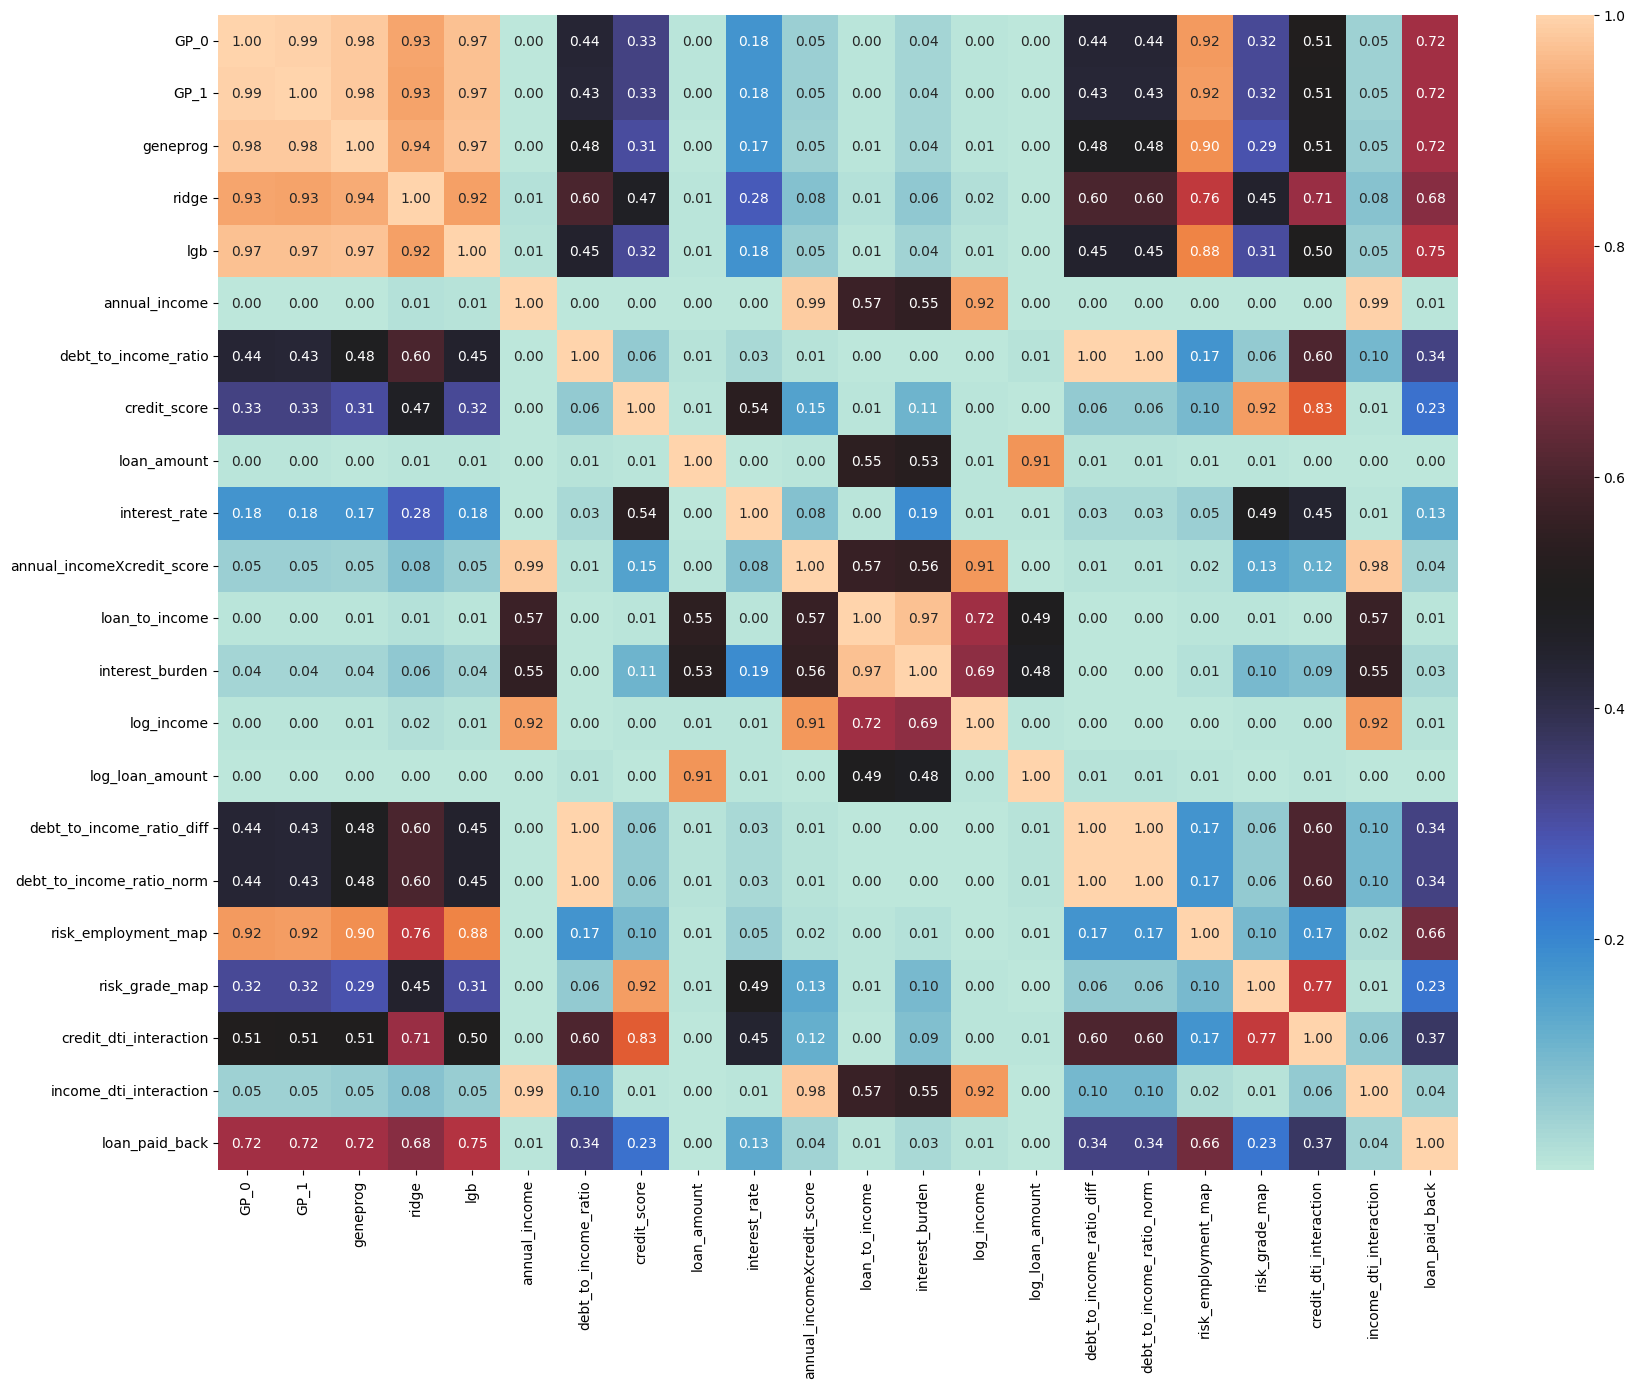

In [3]:
hm = df.corr().abs()
plt.figure(figsize=(20,15))
sns.heatmap(data=hm, cmap="icefire", annot=True, fmt="0.2f")

plt.show()

In [4]:
lasso = LogisticRegression(
    random_state=42,
    penalty="elasticnet",
    solver="saga",
    class_weight="balanced",
    max_iter=2000,
    l1_ratio=0.2,
    C=9,
    n_jobs=-1,
)
select = ["ridge", "lgb", "credit_dti_interaction"]
lasso.fit(X[select], y)

c:\Users\Blanc\AppData\Local\pypoetry\Cache\virtualenvs\playground-lwZmZsxv-py3.12\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=9, class_weight='balanced', l1_ratio=0.2, max_iter=2000,
                   n_jobs=-1, penalty='elasticnet', random_state=42,
                   solver='saga')

In [5]:
ec = pd.DataFrame(data={"coef": lasso.coef_.squeeze()}, index=lasso.feature_names_in_)
ec

,coef
ridge,1.593891
lgb,5.270991
credit_dti_interaction,0.002356


In [6]:
ensenblePrediction = pd.DataFrame(
  {"loan_paid_back": lasso.predict(X_pred[select])},
  index=X_pred.index
)
ensenblePrediction.reset_index().to_parquet(submissions_dir + "submission.parquet")